# US Domestic box office model
Developed by Gene Vaughan

For whatever reason, the amount of money that a movie makes during its theatrical run is the focus of more than just niche interest. Articles about the top grossing films of any given weekend are not hard to find, nor are articles about massive box office successes or catastrophic flops. Clearly, being able to accurately predict a film's financial success or failure before its release (or during its development) would be a massive boon to Hollywood, but there are so many factors involved that such predictive power will likely never exist. Who stars in the film? Who signed on to direct? Who wrote it? Scored it? What's the genre? What other films will it release against? How much was it advertised? What is the perception of the advertising? Is it a franchise film? Is there fatigue around the franchise? Will there be a global pandemic going on? And how are these variables entered into an equation to produce a final box office gross?

My model ignores all such questions at the not-insubstantial cost of only being predictive until over a week after a film has been released, and only applies to the domestic box office. It is reasonable to question the utility of such a model. Films often make a large percentage of their final gross during their first week in theaters. The purpose of my model is instead to learn about Americans' movie-watching behavior under standard conditions. These conditions are essentially: 1) the movie gets a broad opening and 2) doesn't release around the holidays. Under these conditions, there is basically an exponential decay curve that describes the cumulative gross (more people see the movie early on, with diminishing returns the longer it has been in theaters). With such curves, you essentially need a limit that the curve approaches (a final gross) and a rate at which it approaches that limit (a time constant). Films that are "leggier" have lower time constants (meaning they face smaller weekly drop-offs in their grosses), essentially meaning they take longer to reach their final gross. On top of the exponential decay curve is a sinusoidal curve that oscillates on a weekly basis. These oscillations essentially represent the fact that more people see movies on weekends than on weekdays. These oscillations also decay like the overall weekly returns of the film, and I use the same time constant for this decay. However, the amplitude of these oscillations depends on how biased the weekend/weekday attendance split is, and may have something to do with the time of year or how child-friendly a movie is.

In the cell below, I run a simple plotting script that shows the equation I derived to model domestic box office over time and how this equation models the film Barbie (2023). If you then run the next two cells, all of the functions for web-scraping (from Box Office Mojo) and modeling a film's key parameters (final gross, time constant, and amplitude) will be in place.

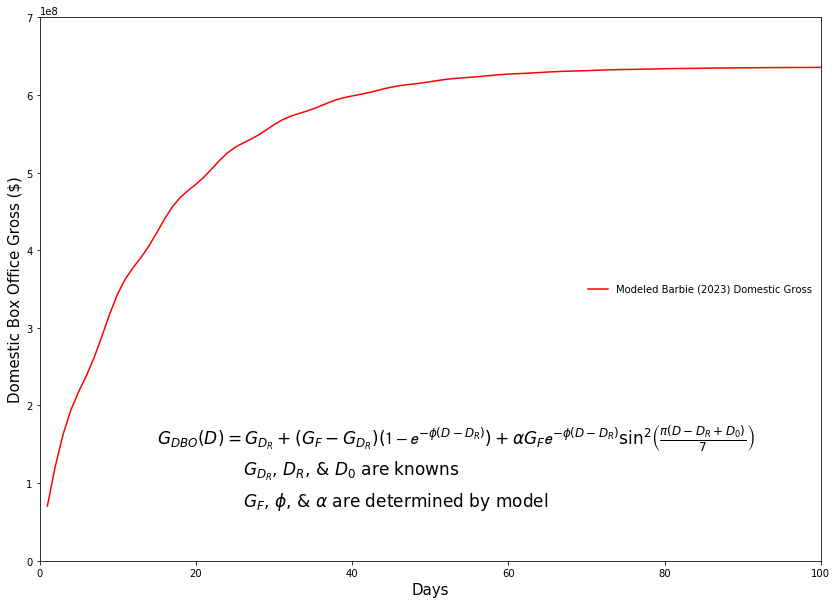

In [2]:
import math
import matplotlib.pyplot as plt

GF = 636000000 # Final domestic gross; this is one of the three parameters the model is fitting
GDR = 70503178 # Reference gross; typically I will use the first day for which data is available, but could be any day
TC = 0.069 # Time constant; this is one of the three parameters the model is fitting
Days = 100 # the number of days you want the model to run over; in practice, just use the number you have data for

Gross = []
for day in range(Days):
    Gross.append(GDR + (GF-GDR)*(1-math.exp(-TC*(day))))

A = 23000000 # Amplitude: alpha x GF, represents the size of weekly revenue oscillations that occur because 
             # more people see movies on weekends
D0 = 1 # number referring to the day of the week; Friday is true premiere day, so it is 0 (+7n), Saturday is 1 (+7n), etc.

Oscillation = []
for day in range(Days):
    Oscillation.append(A*math.exp(-TC*(day))*((math.sin(math.pi*(day+D0)/7))**2))

full = []
for day in range(Days):
    if day == 0:
        full.append(Gross[day])
    else:
        full.append(Gross[day]+Oscillation[day])

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(111)
ax1.plot(range(1,Days+1), full, 'r-', label='Modeled Barbie (2023) Domestic Gross')
plt.axis([0, Days, 0, 700000000])
plt.xlabel("Days", fontsize=15)
plt.ylabel("Domestic Box Office Gross ($)", fontsize=15)
ax1.legend(loc='right', frameon=False)
plt.text(15, 150000000, r'$G_{DBO}(D) = G_{D_R}+(G_F-G_{D_R})(\mathcal{1-e}^{-\phi (D-D_R)})+{\alpha}G_F\mathcal{e}^{-\phi (D-D_R)}\sin^2\left(\frac{\pi(D-D_R+D_0)}{7}\right)$', fontsize = 17)
plt.text(26, 110000000, r'$G_{D_R}$, $D_R$, & $D_0$ are knowns', fontsize = 17)
plt.text(26,  70000000, r'$G_F$, $\phi$, & $\alpha$ are determined by model', fontsize = 17)

plt.show()

In [3]:
# Base code for the model; run first

import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# works exactly like range, but for float intervals
def frange(a, b, step):
    Step = 1/step
    A = a*Step
    B = b*Step
    vals = []
    while A < B:
        vals.append(float(A)/Step)
        A += 1
    return vals

# finds optimal solution
def Gross_calc(Data, GF_range, Time_const_range, Amplitude_range, D0):
    GD = [] # list to store the daily grosses G(D)
    r2 = 0 # initial least squares value
    GD1 = Data[0]
    day_range = range(1, len(Data) + 1, 1)
    r2list = [] # list to store lists of lists of least squares scores
    for gross in GF_range: # loop through final gross values
        r2list2 = []
        for const in Time_const_range: # loop through time constants
            r2list3 = []
            for amp in Amplitude_range: # loop through amplitudes
                for D in range(len(Data)): # loop to find the G(D) values, appending them to the GD list
                    if D == 0 and D0 != 0: # allows reference gross and modeled gross to match on reference day
                        GD.append(GD1)
                    else:
                        GD.append(GD1 + (gross - GD1)*(1 - math.exp(-const*D))\
                                  + amp*math.exp(-const*D)*((math.sin(math.pi*(D + D0)/7))**2))
                    r2 += (Data[D] - GD[D])**2 # find the least squares value for this model fit as you find the model values
                if gross == min(GF_range) and const == min(Time_const_range) and amp == min(Amplitude_range):
                    r2min = r2 # this if statement sets the initial least squares value to be used as the original comparison
                    GF = gross # sets initial gross to prevent errors
                    Phi = const # sets initial time constant to prevent errors
                    Amplitude = amp # sets initial amplitude to prevent errors
                    GD_opt = GD # saves the initial G(D) values to prevent errors
                if r2 < r2min: # continually finds the new best least squares value
                    r2min = r2 # saves minimum least squares sum so far
                    GF = gross # saves the final gross from the best fit
                    Phi = const # saves time constant from the best fit
                    Amplitude = amp # saves amplitude from the best fit
                    GD_opt = GD # saves the G(D) values from the best fit
                r2list3.append(r2)
                GD = [] # empties the G(D) for the next loop
                r2 = 0 # resets the least squares value for the next loop
            r2list2.append(r2list3)
        r2list.append(r2list2)
    return [r2min, GF, Phi, Amplitude, GD_opt, day_range, r2list]

# allows for plotting of error components
def model_components(Data, model, D0):
    error1 = [] # array for (Data - primary curve)
    error2 = [] # array for (Data - primary curve - oscillatory curve)
    error3 = [] # array for (Data - entire model)
    flatline = [] # array of zeros
    GD1 = Data[0]
    GF = model[1]
    Phi = model[2]
    Amplitude = model[3]
    GD_opt = model[4]
    for D in range(len(Data)):
        if D == 0 and D0 != 0: # ensures no error for reference day
            error1.append(0)
            error2.append(0)
            error3.append(0)
            flatline.append(0)
        else: # calculates error for model
            error1.append(Data[D] - GD1 - (GF - GD1)*(1 - math.exp(-Phi*D)))
            error2.append(error1[D] - Amplitude*math.exp(-Phi*D)*((math.sin(math.pi*(D + D0)/7))**2))
            error3.append(Data[D] - GD_opt[D])
            flatline.append(0)
    return [error1, error2, error3, flatline]

# Print the relevant parameters
def parameters(model, movie):
    print(movie)
    print("Final Gross: $" + str(model[1]))
    print("Time constant: " + str(model[2]))
    print("Amplitude: $" + str(model[3]))
    print("Least squares value: " + str(model[0]))

# plots model and data
def model_plot(Data, model, ymin, ymax):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(model[5], Data, 'r-', label='Box Office Data')
    ax.plot(model[5], model[4], 'b-', label='Model')
    plt.axis([0, len(Data) + 1, ymin, ymax])
    plt.xlabel("Days")
    plt.ylabel("Domestic Box Office Gross ($)")
    ax.legend(loc='lower right', frameon=False)
    plt.show()

# plots model error and data residuals to check fit more precisely
def model_error_plot(model, model_err):
    fig = plt.figure()
    # code for seeing the error of the whole model against the actual code
    ax = plt.subplot(111)
    ax.plot(model[5], model_err[2], 'c-')
    ax.plot(model[5], model_err[3], 'k--')
    ax.set_ylabel('Dollars ($)')
    ax.set_title('Total Error in Dollars (Data - Model)')
    
    plt.tight_layout()
    plt.xlim(0, len(model[5]))
    plt.xlabel("Days")
    plt.show()

#shows heatmaps of least squares scores on a log scale to show the region of good solutions
def r2_heatmap(model, GF_range, Time_const_range, Amplitude_range):
    r2list = model[6]
    GF_index = GF_range.index(model[1])
    Phi_index = Time_const_range.index(model[2])
    Amp_index = Amplitude_range.index(model[3])
    # obtain the array for GF being held constant
    GF_const = r2list[GF_index] # within lists, amplitude changes; across lists, phi changes
    GF_const_max = 0
    for indiv_list in GF_const:
        for val in indiv_list:
            if val > GF_const_max:
                GF_const_max = val
    # obtain the array for time constant being held constant
    Phi_const = [] # within lists, amplitude changes; across lists, GF changes
    Phi_const_max = 0
    for indiv_list in r2list:
        for list_index in range(len(indiv_list)):
            if list_index == Phi_index:
                Phi_const.append(indiv_list[list_index])
    for indiv_list in Phi_const:
        for val in indiv_list:
            if val > Phi_const_max:
                Phi_const_max = val
    # obtain the array for amplitude being held constant
    Amp_const = [] # within lists, time constant changes; across lists, GF changes
    Amp_const_max = 0
    for indiv1_list in r2list:
        Amp_const_sub = []
        for indiv2_list in indiv1_list:
            for list_index in range(len(indiv2_list)):
                if list_index == Amp_index:
                    Amp_const_sub.append(indiv2_list[list_index])
                if indiv2_list[list_index] > Amp_const_max:
                    Amp_const_max = indiv2_list[list_index]
        Amp_const.append(Amp_const_sub)

    fig = plt.figure(figsize=(20, 5))
    # plots least squares for all GF and time constant values, holding optimal amplitude constant
    fig.add_subplot(1, 3, 1)
    ax1 = plt.imshow(Amp_const, norm=colors.LogNorm(vmin=Model[0], vmax=Amp_const_max),\
                     aspect='auto', extent=[min(Time_const_range), max(Time_const_range), max(GF_range), min(GF_range)])
    plt.title('Optimal amplitude held constant')
    plt.xlabel('Time constant (1/day)')
    plt.ylabel('Final Gross ($)')
    cbar1 = plt.colorbar()
    cbar1.set_label('Least squares fit', rotation=90)
    plt.tight_layout()
    # plots least squares for all amplitude and time constant values, holding optimal GF constant
    fig.add_subplot(1, 3, 2)
    ax2 = plt.imshow(GF_const, norm=colors.LogNorm(vmin=Model[0], vmax=GF_const_max),\
                     aspect="auto", extent=[min(Amplitude_range), max(Amplitude_range),\
                                            max(Time_const_range), min(Time_const_range)])
    plt.title('Optimal final gross held constant')
    plt.xlabel('Amplitude ($)')
    plt.ylabel('Time constant (1/day)')
    cbar2 = plt.colorbar()
    cbar2.set_label('Least squares fit', rotation=90)
    plt.tight_layout()
    # plots least squares for all GF and amplitude values, holding optimal time constant, well, constant
    fig.add_subplot(1, 3, 3)
    ax3 = plt.imshow(Phi_const, norm=colors.LogNorm(vmin=Model[0], vmax=Phi_const_max),\
                     aspect='auto', extent=[min(Amplitude_range), max(Amplitude_range), max(GF_range), min(GF_range)])
    plt.title('Optimal time constant held constant')
    plt.xlabel('Amplitude ($)')
    plt.ylabel('Final Gross ($)')
    cbar3 = plt.colorbar()
    cbar3.set_label('Least squares fit', rotation=90)
    plt.tight_layout()
    plt.show()

In [4]:
# base code for web scraping; run second
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re

# Attempts to get the content at `url` by making an HTTP GET request. 
# If the content-type of response is some kind of HTML/XML, return the
# text content, otherwise return None.
def simple_get(url):
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

# Returns True if the response seems to be HTML, False otherwise.
def is_good_response(resp):
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)

# Determines indices where the input pattern is found in the input string; output is a list of these indices
def parser(pattern, string):
    parse_output = []
    index = 0
    import re
    while len(string) > 0:
        if re.match(pattern, string):
            parse_output.append(index)
        index = index + 1
        string = string[1:]
    return parse_output

# Takes in a url with the daily box office data from Box Office Mojo; outputs a list of the daily cumulative total,
# the title, and the daily offset determined by the premiere day
def data_find(url):
    Day_codes = {'Friday' : 1, 'Saturday' : 2, 'Sunday' : 3, 'Monday' : 4, 'Tuesday' : 5, 'Wednesday' : 6, 'Thursday' : 0}
    
    raw_html = simple_get(url) # takes the html source code from the page
    html_str = raw_html.decode() # turns the source code into a string
    starts = parser(r'</tr><tr>', html_str) # finds the blocks of html data for each day (with extra stuff at the start)
    end = parser(r'</tr></table>', html_str) # finds the end of the blocks
    starts.append(end[0]) # appends the end to the list of start data
    
    data = [] # initializes a list to put the daily cumulative total grosses in
    for ind in range(len(starts[:-1])): # loops through each day's block of data
        day_data = html_str[starts[ind]:starts[ind + 1]] # establishes a block for a day
        money_spots = parser(r'estimatable">\$', day_data)
        raw_money = day_data[money_spots[2]+14:money_spots[2]+27]
        clean_gross = ''
        for char in raw_money: # loops through each character in the number
            if re.match(r'[0-9]', char): # tests for actual digits
                clean_gross += char # adds digits to the string
        data.append(int(clean_gross)) # converts number to an int and adds it to the data list that we will output
        
    title_raw = re.search(r'<title dir="ltr">.{1,100} - Box Office Mojo', html_str).group() # finds the title in the html source code
    full_title = title_raw[17:-18] # cleans up the title
    D0_find = re.search(r'table_1">.{1,8}day</a>', html_str).group() # finds day of the week of release
    D0 = Day_codes[D0_find[9:-4]] #assigns release day a number as per Day_codes
    
    return [data, full_title, D0]

# Running the model
To actually use the model for an individual movie, you basically just need to input a range of guesses for the different estimated parameters. The model will then show you the optimal retrieved value for each parameter, a plot showing how well the model matches the data, a plot showing the error of the model, and three plots showing the r-squared values for each modeled parameter set, so that you can tell whether you've found the globally optimal solution. I have demonstrated the model on Barbie (2023) and Dune: Part Two (2024). 

Barbie
Final Gross: $636000000
Time constant: 0.069
Amplitude: $23000000
Least squares value: 375724953263477.0


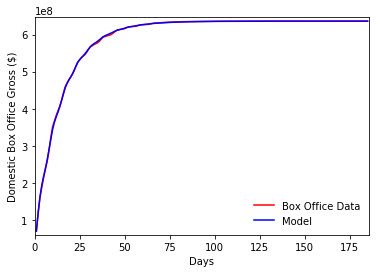

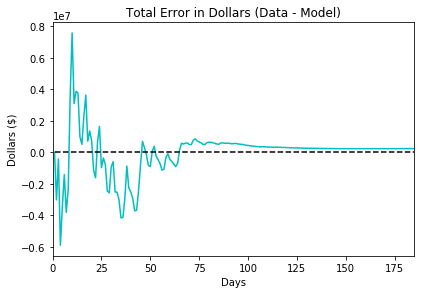

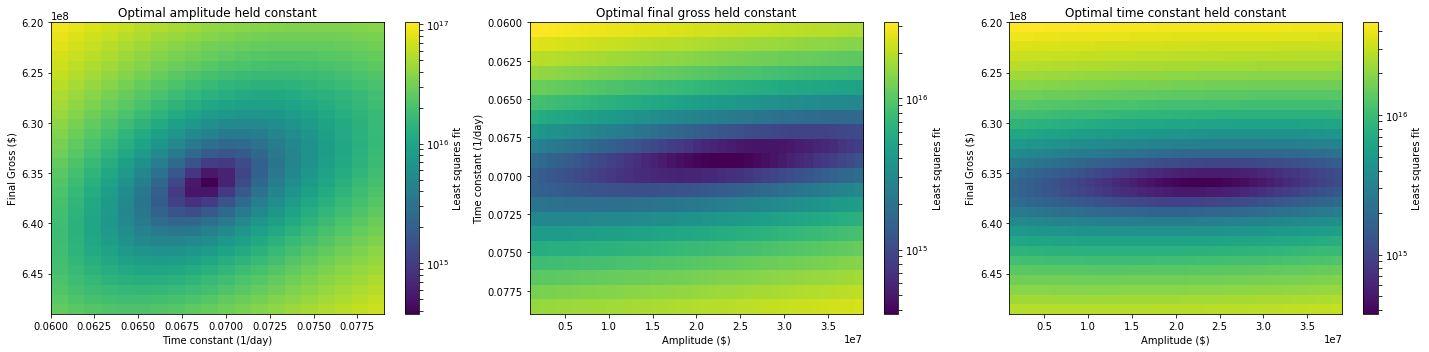

In [5]:
#Barbie (2023); use the daily domestic box office data from Box Office Mojo (sample URL below) for any tested movie
Online_data = data_find('https://www.boxofficemojo.com/release/rl1077904129/?ref_=bo_rl_tab#tabs')

Data = Online_data[0]
Title = Online_data[1]

# range of approximate guesses for final gross; modulate using the three windows at the bottom of the output as necessary
GF_min =    620000000
GF_max =    650000000
GF_interval = 1000000
GF_range = range(GF_min, GF_max, GF_interval)

# range of approximate guesses for time constants; modulate using the three windows at the bottom of the output as necessary
Time_const_min =      0.06
Time_const_max =      0.08
Time_const_interval = 0.001
# function intended for decimal steps; use "range" if you somehow use whole number steps
Time_const_range = frange(Time_const_min, Time_const_max, Time_const_interval)

# range of approximate guesses for weekly amplitude; modulate using the three windows at the bottom of the output as necessary
Amplitude_min =      1000000
Amplitude_max =     40000000
Amplitude_interval = 1000000
Amplitude_range = range(Amplitude_min, Amplitude_max, Amplitude_interval) 

# number of days of offset for the peaks of oscillation in each week, depends on day of week of reference day:
# Friday    Saturday  Sunday    Monday    Tuesday   Wednesday Thursday
# 1         2         3         4         5         6         0
D0 = Online_data[2]

# number of days you want to include; use "len(Data)" for all days
Days = len(Data)

# Run functions
Model = Gross_calc(Data[:Days + 1], GF_range, Time_const_range, Amplitude_range, D0)
Model_err = model_components(Data[:Days + 1], Model, D0)
parameters(Model, Title)
# for model_plot, second and third arguments determine range of values displayed;
# can also use "min(Data[:Days + 1]) - x, max(Data[:Days + 1]) + y"
model_plot(Data[:Days + 1], Model, min(Data[:Days + 1]) - 10000000, max(Data[:Days + 1]) + 10000000)
model_error_plot(Model, Model_err)
r2_heatmap(Model, GF_range, Time_const_range, Amplitude_range)

Dune: Part Two
Final Gross: $285000000
Time constant: 0.065
Amplitude: $21000000
Least squares value: 75993925138635.45


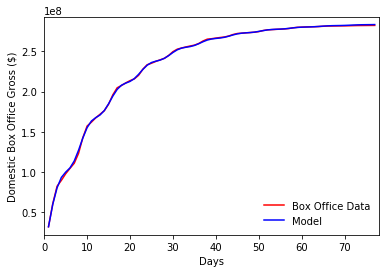

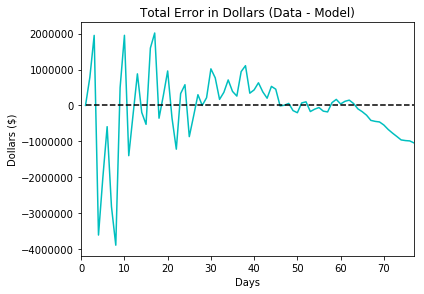

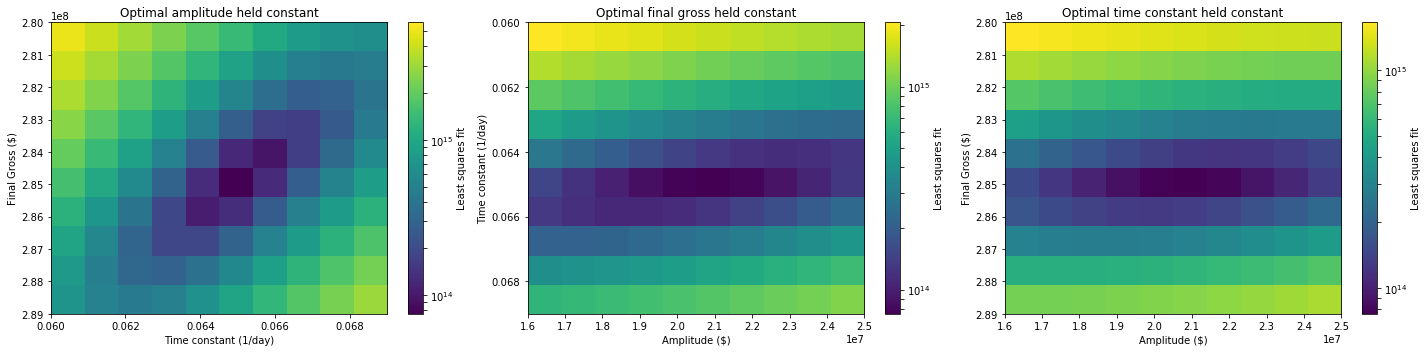

In [6]:
# Dune: Part Two
Online_data = data_find('https://www.boxofficemojo.com/release/rl68715265/?ref_=bo_rl_tab#tabs')

Data = Online_data[0]
Title = Online_data[1]

# range of approximate guesses for final gross
GF_min =    280000000
GF_max =    290000000
GF_interval = 1000000
GF_range = range(GF_min, GF_max, GF_interval)

# range of approximate guesses for time constants
Time_const_min =      0.06
Time_const_max =      0.07
Time_const_interval = 0.001
# function intended for decimal steps; use "range" if you somehow use whole number steps
Time_const_range = frange(Time_const_min, Time_const_max, Time_const_interval)

# range of approximate guesses for weekly amplitude
Amplitude_min =     16000000
Amplitude_max =     26000000
Amplitude_interval = 1000000
Amplitude_range = range(Amplitude_min, Amplitude_max, Amplitude_interval) 

# number of days of offset for the peaks of oscillation in each week, depends on day of week of reference day:
# Friday    Saturday  Sunday    Monday    Tuesday   Wednesday Thursday
# 1         2         3         4         5         6         0
D0 = Online_data[2]

# number of days you want to include; use "len(Data)" for all days
Days = len(Data)

# Run functions
Model = Gross_calc(Data[:Days + 1], GF_range, Time_const_range, Amplitude_range, D0)
Model_err = model_components(Data[:Days + 1], Model, D0)
parameters(Model, Title)
# for model_plot, second and third arguments determine range of values displayed;
# can also use "min(Data[:Days + 1]) - x, max(Data[:Days + 1]) + y"
model_plot(Data[:Days + 1], Model, min(Data[:Days + 1]) - 10000000, max(Data[:Days + 1]) + 10000000)
model_error_plot(Model, Model_err)
r2_heatmap(Model, GF_range, Time_const_range, Amplitude_range)

# Compiling results
I ran the model on 100 different films from over the last six years to check for relationships between the three fitted parameters. I put this data into lists below, but I also have the data recorded in a spreadsheet that I've shared.

While there is a supported relationship between time constant and final gross, it is not a nearly strong enough relationship to reduce one of these parameters into a function of the other. Instead, it simply stands to reason that the more money a movie makes, the more slowly it is likely to have done it; theaters may approach capacity for the most popular films, causing some people to wait longer to see them, or positive word of mouth may prevent rapid decline in viewership. Meanwhile, lower grossing films may make all their money very quickly or very slowly, forming a large column of different time constants in the low final gross area.

There is no supported correlation between final gross and amplitude coefficient (amplitude over final gross), with amplitude coefficients typically being around the value 0.1, but with a lot of variation. 

Interestingly, there is a strong relationship between amplitude coefficient and time constant; still too noisy to fully eliminate one of these two variables, but noteworthy. A lower time constant (leggier film) tends to align with a lower amplitude coefficient (relatively smaller weekend bumps in gross), and a higher time constant (for short-lived films) tends to align with a higher amplitude coefficient (higher share of profit made on weekends). This could indicate that films with more staying power tend to have a strong draw for audiences even on weekdays, instead of only being worth seeing on the more convenient weekends. It interesting to look into other variables, like whether summer movies or movies aimed at children tend have a different amplitude coefficient.

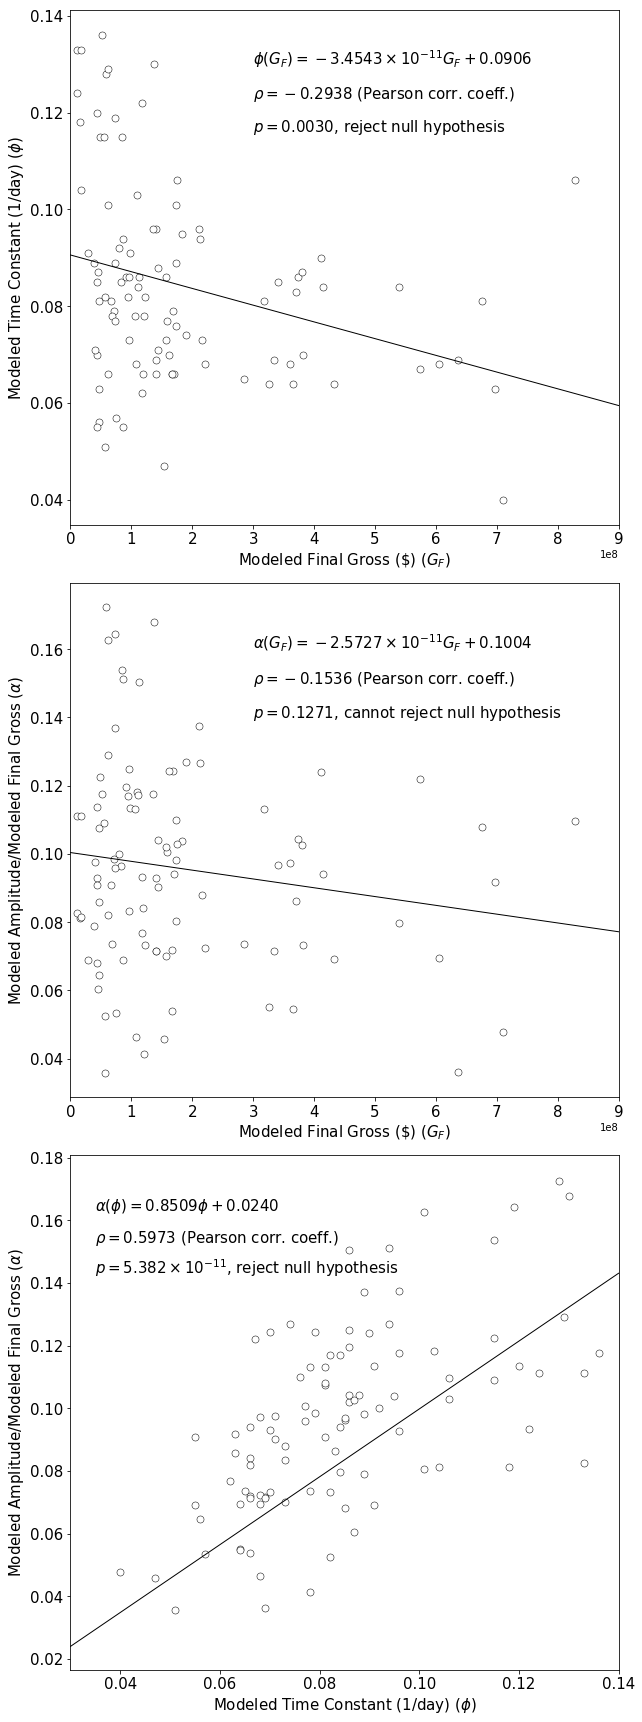

In [7]:
import numpy as np
import scipy.stats

Modeled_GF = [285000000, 636000000, 326000000,  71000000, 574000000, 360000000, 382000000, 167000000, 159000000,  83000000, \
              174000000, 157000000,  61500000,  94000000,  84500000, 137000000,  92000000, 119000000,  46500000,  68000000, \
               58000000,  73000000,  43000000,  44000000,  56000000,  66000000,  16000000,  29000000, 711000000, 374000000, \
              411000000,  73000000, 371000000, 341000000,  96000000, 189000000, 169000000, 153000000, 366000000, 118000000, \
               46600000,  10800000,  44700000, 123000000,  96000000,  44000000,  97000000,  73000000,  46500000, 173000000, \
              108000000, 183000000,  87000000, 117000000,  57000000,  41000000,  44000000,  38000000,  10900000,  17200000, \
              829000000, 540000000, 335000000, 380000000, 433000000, 173000000, 161000000, 211000000, 144000000, 157000000, \
               86000000, 110000000, 140000000, 140000000, 113000000, 170000000,  62000000, 175000000,  80000000, 111000000, \
              106000000,  49000000,  75000000,  61000000,  55000000,  18000000, 213000000, 121000000, 697000000, 415000000, \
              605000000, 221000000, 318000000, 216000000, 136000000, 144000000, 167000000,  51000000, 140000000, 676000000]

Modeled_TC = [0.065, 0.069, 0.064, 0.079, 0.067, 0.068, 0.070, 0.066, 0.077, 0.085, \
              0.101, 0.086, 0.101, 0.082, 0.115, 0.130, 0.086, 0.066, 0.056, 0.078, \
              0.128, 0.077, 0.070, 0.085, 0.051, 0.081, 0.118, 0.091, 0.040, 0.086, \
              0.090, 0.119, 0.083, 0.085, 0.086, 0.074, 0.079, 0.047, 0.064, 0.122, \
              0.063, 0.124, 0.087, 0.082, 0.073, 0.120, 0.091, 0.089, 0.081, 0.089, \
              0.068, 0.095, 0.055, 0.062, 0.082, 0.071, 0.055, 0.089, 0.133, 0.104, \
              0.106, 0.084, 0.069, 0.087, 0.064, 0.076, 0.070, 0.096, 0.088, 0.073, \
              0.094, 0.103, 0.066, 0.096, 0.086, 0.066, 0.129, 0.106, 0.092, 0.084, \
              0.078, 0.115, 0.057, 0.066, 0.115, 0.133, 0.094, 0.078, 0.063, 0.084, \
              0.068, 0.068, 0.081, 0.073, 0.096, 0.071, 0.066, 0.136, 0.069, 0.081]

Modeled_Am = [21000000, 23000000, 18000000,  7000000, 70000000, 35000000, 28000000, 12000000, 16000000,  8000000, \
              14000000, 16000000, 10000000, 11000000, 13000000, 23000000, 11000000, 10000000,  3000000,  5000000, \
              10000000,  7000000,  4000000,  3000000,  2000000,  6000000,  1300000,  2000000, 34000000, 39000000, \
              51000000, 12000000, 32000000, 33000000, 12000000, 24000000, 21000000,  7000000, 20000000, 11000000, \
               4000000,  1200000,  2700000,  9000000,  8000000,  5000000, 11000000, 10000000,  5000000, 17000000, \
               5000000, 19000000,  6000000,  9000000,  3000000,  4000000,  4000000,  3000000,   900000,  1400000, \
              91000000, 43000000, 24000000, 39000000, 30000000, 19000000, 20000000, 29000000, 15000000, 11000000, \
              13000000, 13000000, 10000000, 13000000, 17000000, 16000000,  8000000, 18000000,  8000000, 13000000, \
              12000000,  6000000,  4000000,  5000000,  6000000,  2000000, 27000000,  5000000, 64000000, 39000000, \
              42000000, 16000000, 36000000, 19000000, 16000000, 13000000, 9000000,   6000000, 10000000, 73000000]

Am_frac = []
for index in range(len(Modeled_Am)):
    Am_frac.append(Modeled_Am[index]/Modeled_GF[index])

#result3 = scipy.stats.linregress(np.array(Modeled_TC), np.array(Am_frac))
#print(result3.rvalue)
#print(result3.pvalue)

fig = plt.figure(figsize=(9, 24))
ax1 = fig.add_subplot(311)
ax1.plot([0, 900000000], [0.0906, 0.0595], linewidth=1, color='k')
ax1.scatter(Modeled_GF, Modeled_TC, s=50, c='w', linewidths=0.5, edgecolors='k')
ax1.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Modeled Final Gross (\$) (${G_F}$)', fontsize=15)
plt.ylabel('Modeled Time Constant (1/day) (${\phi}$)', fontsize=15)
plt.text(300000000, 0.13, "${\phi(G_F) = -3.4543\\times10^{-11}G_F + 0.0906}$", fontsize = 15)
plt.text(300000000, 0.123, "${\\rho = -0.2938}$ (Pearson corr. coeff.)", fontsize = 15)
plt.text(300000000, 0.116, "${p = 0.0030}$, reject null hypothesis", fontsize = 15)
plt.xlim(0, 900000000)
plt.tight_layout(pad = 1)

ax2  = fig.add_subplot(312)
ax2.plot([0, 900000000], [0.1004, 0.0772], linewidth=1, color='k')
ax2.scatter(Modeled_GF, Am_frac, s=50, c='w', linewidths=0.5, edgecolors='k')
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Modeled Final Gross (\$) (${G_F}$)', fontsize=15)
plt.ylabel('Modeled Amplitude/Modeled Final Gross (${\\alpha}$)', fontsize=15)
plt.text(300000000, 0.16, "${\\alpha(G_F) = -2.5727\\times10^{-11}G_F + 0.1004}$", fontsize = 15)
plt.text(300000000, 0.15, "${\\rho = -0.1536}$ (Pearson corr. coeff.)", fontsize = 15)
plt.text(300000000, 0.14, "${p = 0.1271}$, cannot reject null hypothesis", fontsize = 15)
plt.xlim(0, 900000000)
plt.tight_layout(pad = 1)

ax3  = fig.add_subplot(313)
ax3.plot([0.03, 0.14], [0.02396, 0.14309], linewidth=1, color='k')
ax3.scatter(Modeled_TC, Am_frac, s=50, c='w', linewidths=0.5, edgecolors='k')
ax3.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Modeled Time Constant (1/day) (${\phi}$)', fontsize=15)
plt.ylabel('Modeled Amplitude/Modeled Final Gross (${\\alpha}$)', fontsize=15)
plt.text(0.035, 0.163, "${\\alpha(\phi) = 0.8509\phi + 0.0240}$", fontsize = 15)
plt.text(0.035, 0.153, "${\\rho = 0.5973}$ (Pearson corr. coeff.)", fontsize = 15)
plt.text(0.035, 0.143, "${p = 5.382\\times10^{-11}}$, reject null hypothesis", fontsize = 15)
plt.xlim(0.03, 0.14)
plt.tight_layout(pad = 1)
plt.show()

# Considering Budget
Finally, I considered whether a film's budget was in any way related to the three fitted parameters, and plotted all three parameters and budget on a single plot (using marker color to show amplitude coefficient and marker size to show how much a film grossed domestically as a percentage of its budget). This provided no particular additional insight (e.g., the plot is not divided into 'bomb' and 'smash hit' regions), but it was sufficiently visually interesting that I decided to include it here for posterity.

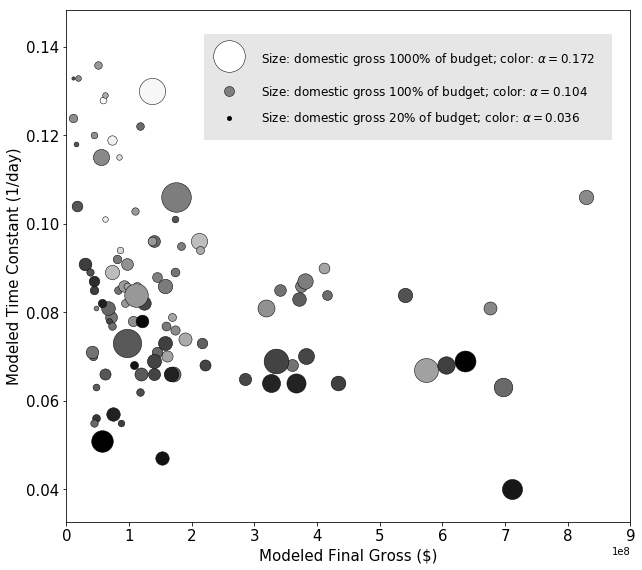

In [8]:
from matplotlib.patches import Rectangle

Budget = [190000000, 145000000, 100000000,  50000000, 100000000, 250000000, 150000000, 100000000, 200000000, 139000000, \
          387000000,  75000000, 200000000, 150000000, 275000000,  20000000,  70000000,  70000000,  75000000, 200000000, \
          125000000, 125000000,  60000000,  60000000,  12000000,  35000000,  70000000,  18000000, 177000000, 265000000, \
          351000000,  83000000, 200000000, 250000000, 200000000, 110000000, 260000000,  85000000, 100000000, 200000000, \
          100000000,  15000000,  40000000,  68000000,  12000000, 100000000,  70000000,  36000000, 200000000, 225000000, \
          165000000, 288500000, 200000000, 200000000,  82000000,  26000000,  79000000,  70000000, 100000000,  15000000, \
          400000000, 260000000,  55000000, 160000000, 200000000, 200000000, 129000000,  79000000, 150000000,  80000000, \
          200000000, 200000000,  96000000, 100000000, 170000000,  75000000, 196000000,  20000000, 110000000,  20000000, \
           99000000, 138000000,  41300000,  49000000,  21000000,  55000000, 330400000,  75000000, 200000000, 432000000, \
          200000000, 180000000, 110000000, 195000000, 175000000, 130000000,  80000000,  88000000,  70000000, 400000000]

Bu_frac = []
for index in range(len(Budget)):
    Bu_frac.append(Modeled_GF[index]/Budget[index])

norm_Am_frac = []
for index in range(len(Am_frac)):
    norm_Am_frac.append((Am_frac[index]-min(Am_frac))/(max(Am_frac)-min(Am_frac)))

fig = plt.figure(figsize=(9, 8))
ax  = fig.add_subplot(111)
for index in range(len(Bu_frac)):
    ax.scatter(Modeled_GF[index], Modeled_TC[index], s=100*Bu_frac[index], c=(norm_Am_frac[index], norm_Am_frac[index], norm_Am_frac[index]), linewidths=0.5, edgecolors='k')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.add_patch(Rectangle((220000000, 0.119), 650000000, 0.024, facecolor=(0.9, 0.9, 0.9)))
ax.scatter(260000000, 0.124,  s=20, c='k', linewidths=0.5, edgecolors='k', zorder=4)
ax.scatter(260000000, 0.130, s=100, c=(0.5, 0.5, 0.5), linewidths=0.5, edgecolors='k', zorder=4)
ax.scatter(260000000, 0.138, s=1000, c='w', linewidths=0.5, edgecolors='k', zorder=4)
ax.text(310000000, 0.123, 'Size: domestic gross 20% of budget; color: ${\\alpha=0.036}$', fontsize=12)
ax.text(310000000, 0.129, 'Size: domestic gross 100% of budget; color: ${\\alpha=0.104}$', fontsize=12)
ax.text(310000000, 0.1365, 'Size: domestic gross 1000% of budget; color: ${\\alpha=0.172}$', fontsize=12)
plt.xlabel('Modeled Final Gross ($)', fontsize=15)
plt.ylabel('Modeled Time Constant (1/day)', fontsize=15)
plt.xlim(0, 900000000)
plt.tight_layout(pad = 1)
plt.show()